# Notebook 4 of the eLetter response to Hubbard & Bradley

In this notebook, we show what the global stack would look like using Green's functions calculated considering different source locations (the case of Tohoku is treated in the supplementary material of Bletery and Nocquet (2023), see Figure S11B and scripts in https://doi.org/10.5281/zenodo.8064086).  

In [1]:
# Library cell

import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
import scipy.optimize
import pyeq.green.make

In [2]:
# Variables declaration cell

L, W = 1, 1           # Length and Width of pre-slip areas (same as in Bletery and Nocquet, 2023)
nlon, nlat = 4, 4     # Number of grid points in the east, west, north and south directions 
                      # Total number of grid points will be (2nlon+1)*(2nlat+1)
grid_spacing = 50     # Gird spacing (in km)
nsample = 576         # Number of samples in the time series (48 h, 5-min sampling --> 576 samples)
nd = int(nsample/2)   # Number of samples in 24 h

In [3]:
# Load data

A = np.genfromtxt('scardec_M7_full.txt')
data_byEQ_dir = 'data_byEQ'
Mw, date, lat, lon, dep = A[:,0], A[:,1:7].astype(int), A[:,7], A[:,8], A[:,9]
strike, dip, rake = A[:,10], A[:,11], A[:,12] 
leq_file = glob(data_byEQ_dir+"/20*_MW_*/station_list.txt")

In [4]:
# Compute Green's functions at the grid locations and save them as txt files 
# Get confrotable. This is going to take some time (but it only needs to be run once)

for i in range(len(lon)): # everything
    
    DATE = []
    for k in range(1,6):
        if date[i,k]<10:
            DATE.append('0'+str(date[i,k]))
        else:
            DATE.append(str(date[i,k]))
    eq_dir = data_byEQ_dir+'/'+str(date[i,0])+DATE[0]+DATE[1]+'T'+DATE[2]+':'+DATE[3]+':'+DATE[4]+'_MW_'+str(Mw[i]) 
    
    if os.path.exists(eq_dir):
        
        eq_file = eq_dir+'/station_list.txt'
        np_code = np.atleast_1d(np.genfromtxt(eq_file,dtype=str,usecols=0))
        st_lon = np.atleast_1d(np.genfromtxt(eq_file,dtype=float,usecols=1))
        st_lat = np.atleast_1d(np.genfromtxt(eq_file,dtype=float,usecols=2))
        array_gps = np.transpose(np.array([st_lon,st_lat]))
        
        LON = lon[i] + np.array(range(-nlon,nlon+1)) * grid_spacing/(111.1*np.cos(np.pi*lat[i]/180))
        LAT = lat[i] + np.array(range(-nlat,nlat+1)) * grid_spacing/111.1
        
        for j in range(2*nlon+1):
            for k in range(2*nlat+1):
        
                geometry = np.array([[LON[j],LAT[k],dep[i],L,W,L*W,1,strike[i],dip[i],0,0,0,0,0,0,0,0,0,0,0,0,0]])
                green = pyeq.green.make.nikkhoo_rde(geometry,array_gps,coor_type='geo',tensile=False,disp=True,strain=False,stress=False,lam=28758000000.0,mu=29353000000.0,verbose=False)
                r_rake = np.radians(rake[i])
                green_east = np.cos(r_rake)*green[0,:,0,0] + np.sin(r_rake)*green[0,:,0,1]
                green_north = np.cos(r_rake)*green[0,:,1,0] + np.sin(r_rake)*green[0,:,1,1]
                green_up = np.cos(r_rake)*green[0,:,2,0] + np.sin(r_rake)*green[0,:,2,1]
                disp = np.transpose([green_east,green_north,green_up])
        
                green_file = eq_dir+'/synthetics_'+str(j)+'_'+str(k)+'.txt'
                np.savetxt(green_file,disp)

In [5]:
# Compute the stacks for all grid locations and save them as txt files (only need to be run once)

for eq_file in leq_file:
    
    np_code = np.atleast_1d(np.genfromtxt(eq_file,dtype=str,usecols=0))
    eq = eq_file.split('/')[-2]
    eq_dir = data_byEQ_dir+'/'+eq
    
    # Exclude events excluded in Bletery and Nocquet (2023) because of obvious ofssets in the time series
    if eq not in ['20040905T10:07:07_MW_7.2','20040905T14:57:18_MW_7.5','20140403T02:43:13_MW_7.7','20190706T03:19:53_MW_7.0']:
    
        for j in range(2*nlon+1):
            for k in range(2*nlat+1):
    
                syn_east = np.atleast_1d(np.genfromtxt(eq_dir+'/synthetics_'+str(j)+'_'+str(k)+'.txt',dtype=float,usecols=0))
                syn_north = np.atleast_1d(np.genfromtxt(eq_dir+'/synthetics_'+str(j)+'_'+str(k)+'.txt',dtype=float,usecols=1))
                dot_product0, dot_product = np.zeros([len(np_code), nsample]), np.zeros([len(np_code), nsample])
                i = 0
    
                for code in np_code:
                    ts = np.genfromtxt(eq_dir+'/TS_'+code+'.dat')
                    east, north = ts[:,7], ts[:,8]
                    east0, north0 = np.median(east[0:nd]), np.median(north[0:nd])
                    norme, normn = np.linalg.norm(east[0:nd]-east0), np.linalg.norm(north[0:nd]-north0)
                    sj2 = norme*norme + normn*normn
                    dot_product0[i,:] = (east-east0)*syn_east[i] + (north-north0)*syn_north[i]
                    dot_product[i,:] = dot_product0[i,:] / sj2
                    i = i+1
                    
                eq_stack = sum(dot_product)
                np.savetxt(eq_dir+'/stack_'+str(j)+'_'+str(k)+'.txt',eq_stack)

In [6]:
# Calculate the ratio ratio between the last point of the moving average and its maximum on the [-48,-2] 
# time window 

wd = 22                # window duration of the moving average (in samples)
Nsma = nsample - wd    # number of samples in the moving average time series
N0 = Nsma - 24         # number of samples of the moving average unafected by the last 2 hours
SMA = [0]*Nsma
stack = np.zeros([2*nlon+1,2*nlat+1,nsample])
t = np.arange(-48-1/24,0-1/24,1/12)

r = np.zeros([2*nlon+1,2*nlat+1])

for j in range(2*nlon+1):
    for k in range(2*nlat+1):
        
        eq_stack = []
        
        for eq_file in leq_file:
    
            np_code = np.atleast_1d(np.genfromtxt(eq_file,dtype=str,usecols=0))
            eq = eq_file.split('/')[-2]
            eq_dir = data_byEQ_dir+'/'+eq
            if eq not in ['20040905T10:07:07_MW_7.2','20040905T14:57:18_MW_7.5','20140403T02:43:13_MW_7.7','20190706T03:19:53_MW_7.0']:
                eq_stack.append(np.genfromtxt(eq_dir+'/stack_'+str(j)+'_'+str(k)+'.txt'))

        stack[j,k,:] = sum(np.array(eq_stack))
        
        for ii in range(Nsma):
            SMA[ii] = np.mean(stack[j,k,ii:ii+wd])
                
        r[j,k] = SMA[-1] / max(SMA[0:N0]) 

Let's start by looking at some stack time series calculated considering sources located 200 km, 100 km, 50 km (and 0 km) away from the true epicenters in the east direction: 

Text(0.5, 0, 'Time before earthquakes (h)')

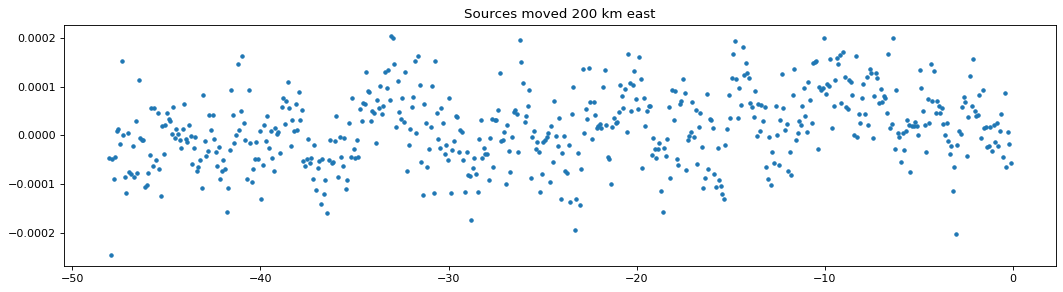

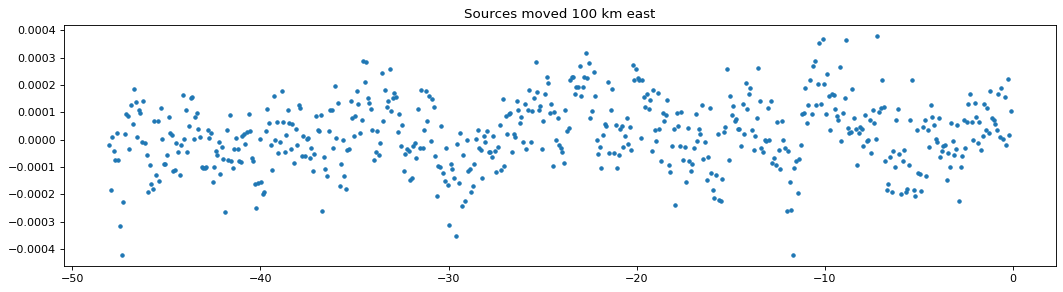

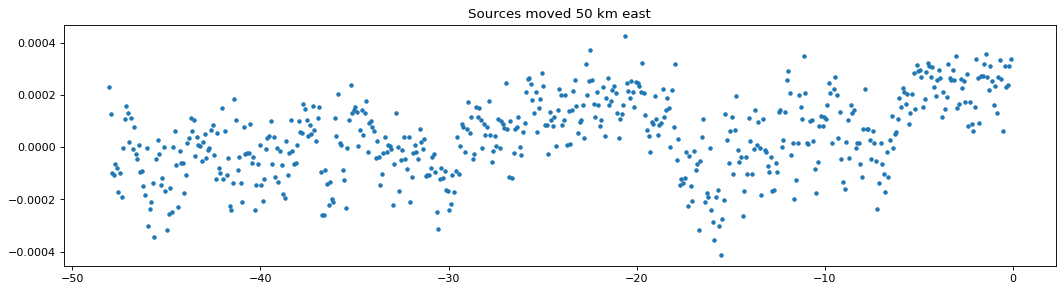

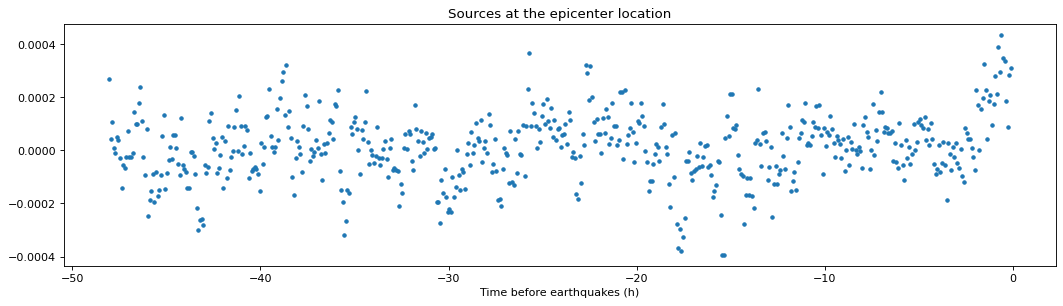

In [7]:
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[8,4,:],'.')
plt.title('Sources moved 200 km east')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[6,4,:],'.')
plt.title('Sources moved 100 km east')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[5,4,:],'.')
plt.title('Sources moved 50 km east')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[4,4,:],'.')
plt.title('Sources at the epicenter location')
plt.xlabel('Time before earthquakes (h)')

Let's now look at the same thing in the west direction:

Text(0.5, 0, 'Time before earthquakes (h)')

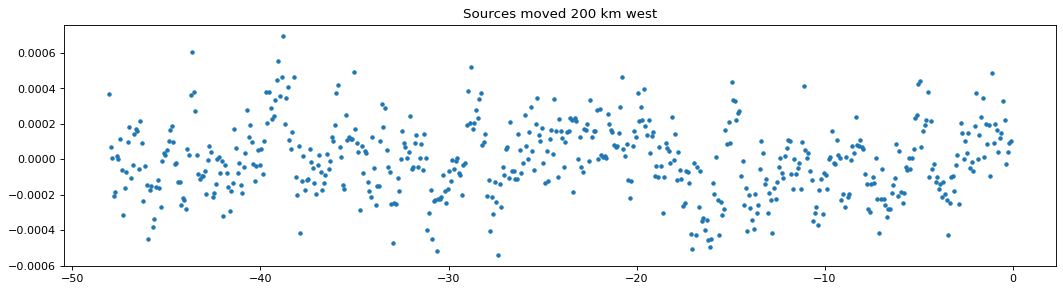

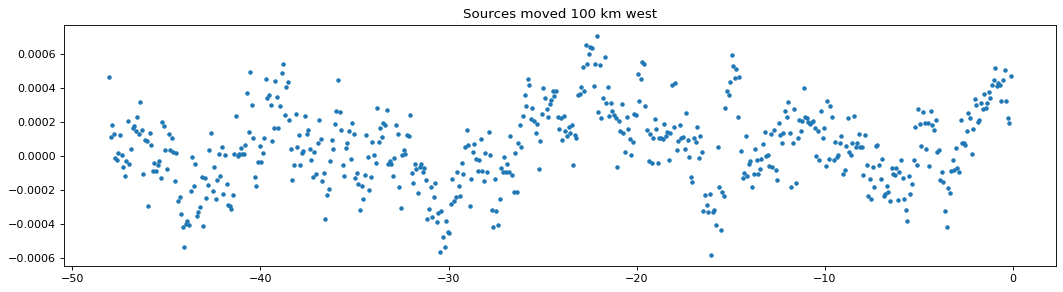

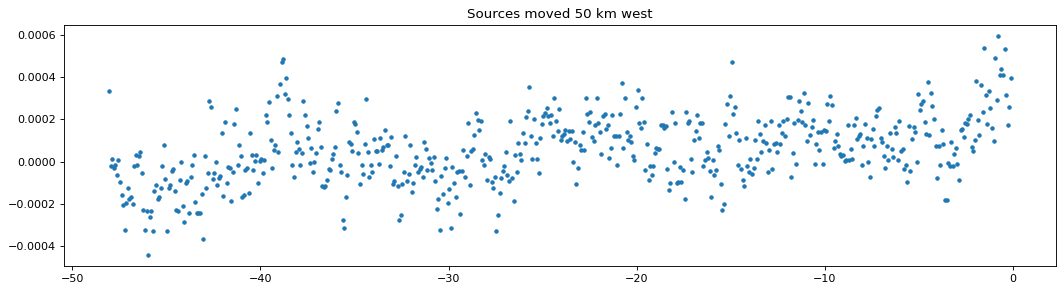

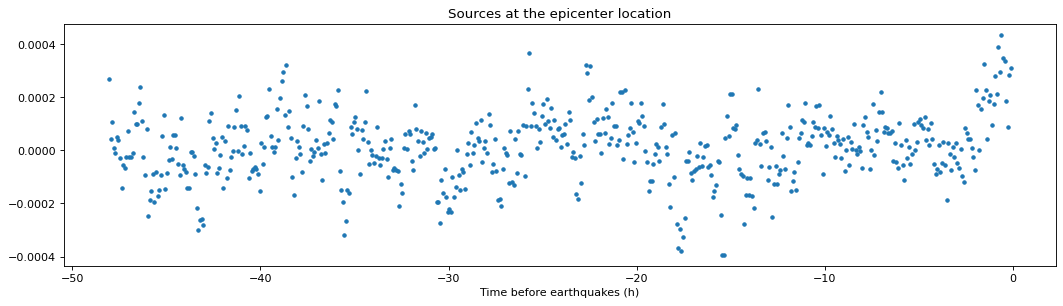

In [8]:
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[0,4,:],'.')
plt.title('Sources moved 200 km west')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[2,4,:],'.')
plt.title('Sources moved 100 km west')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[3,4,:],'.')
plt.title('Sources moved 50 km west')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[4,4,:],'.')
plt.title('Sources at the epicenter location')
plt.xlabel('Time before earthquakes (h)')

in the north direction:

Text(0.5, 0, 'Time before earthquakes (h)')

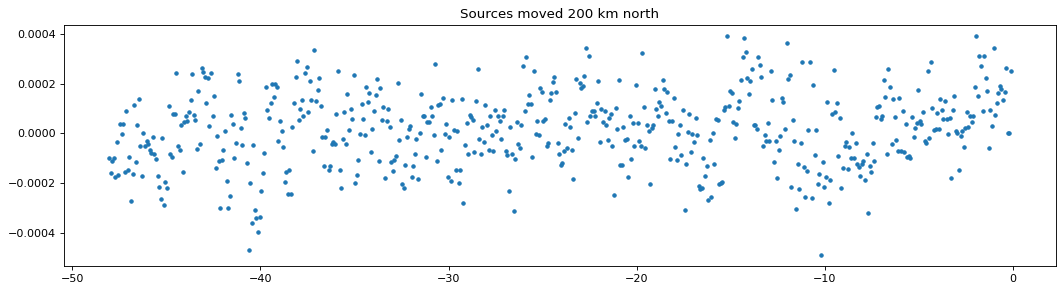

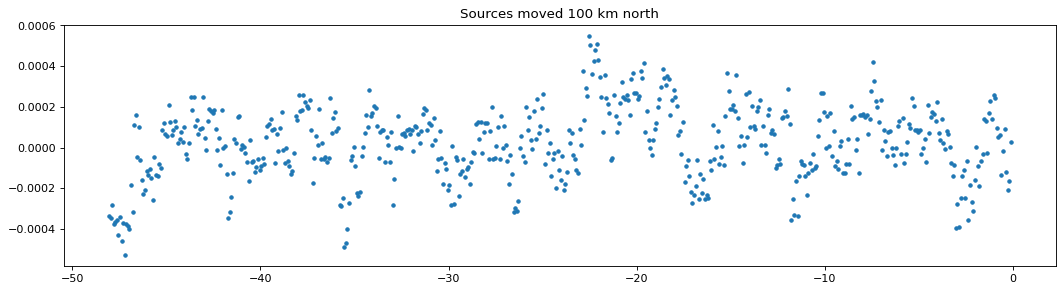

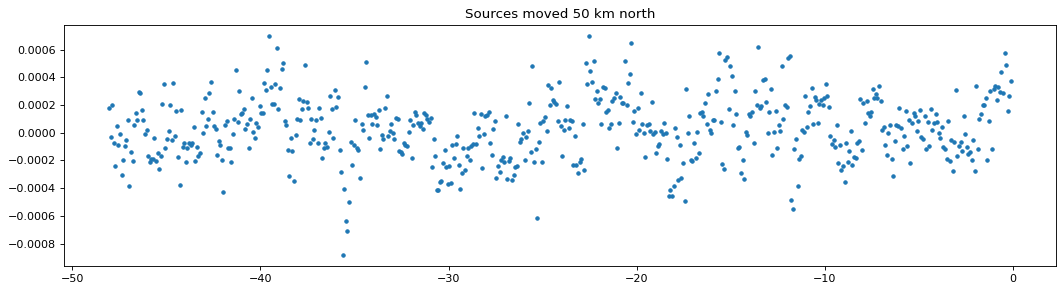

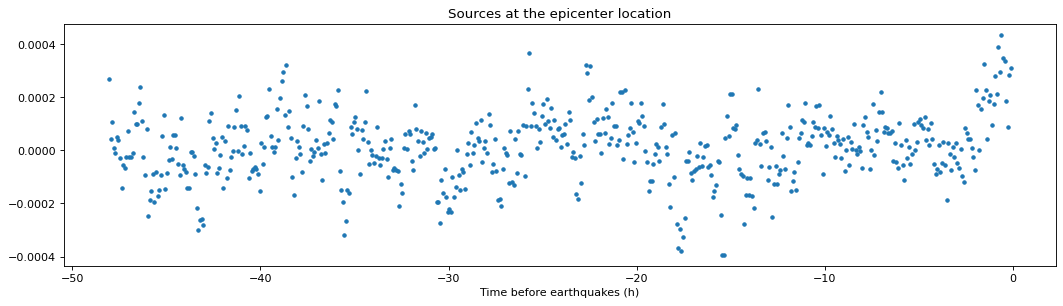

In [9]:
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[4,8,:],'.')
plt.title('Sources moved 200 km north')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[4,6,:],'.')
plt.title('Sources moved 100 km north')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[4,5,:],'.')
plt.title('Sources moved 50 km north')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[4,4,:],'.')
plt.title('Sources at the epicenter location')
plt.xlabel('Time before earthquakes (h)')

and in the south direction:

Text(0.5, 0, 'Time before earthquakes (h)')

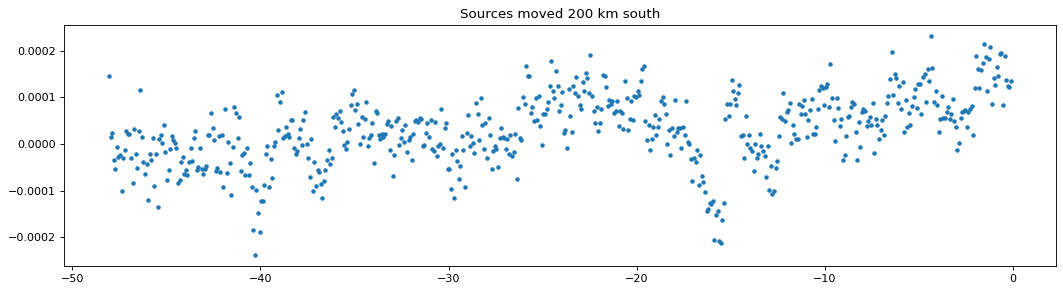

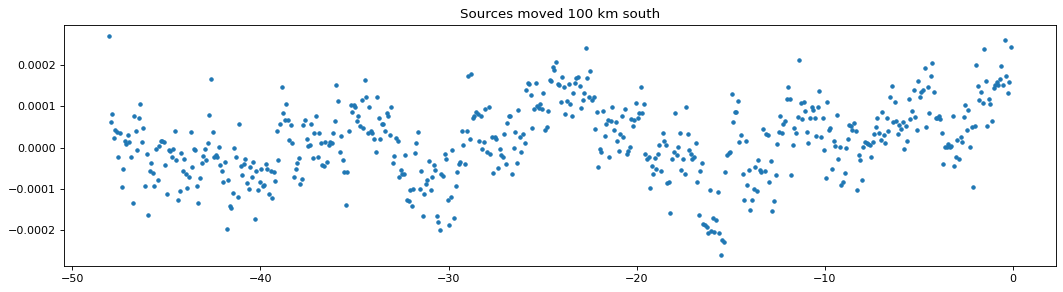

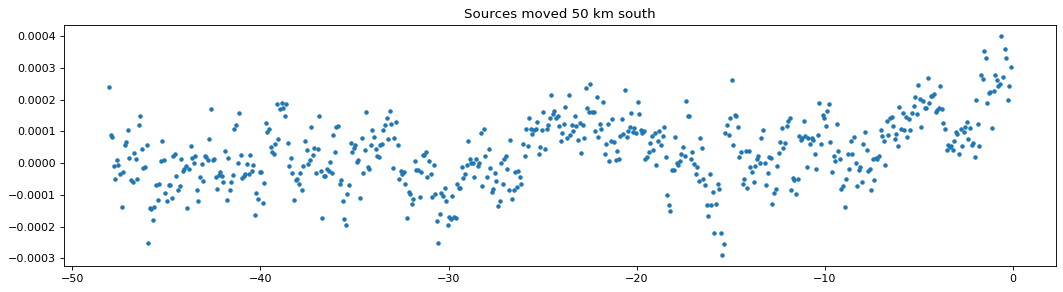

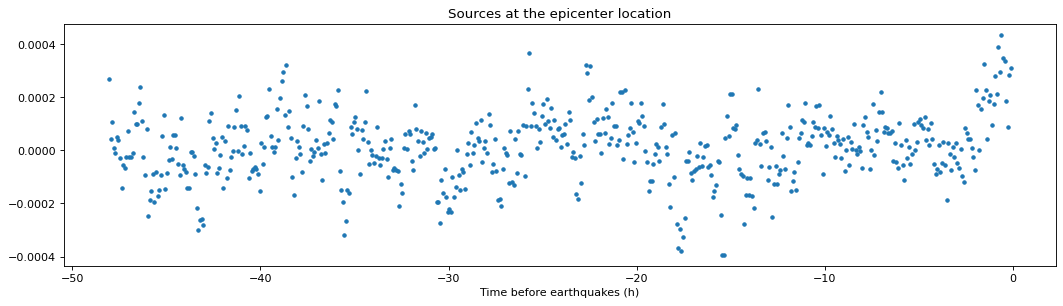

In [10]:
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[4,0,:],'.')
plt.title('Sources moved 200 km south')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[4,2,:],'.')
plt.title('Sources moved 100 km south')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[4,3,:],'.')
plt.title('Sources moved 50 km south')
plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack[4,4,:],'.')
plt.title('Sources at the epicenter location')
plt.xlabel('Time before earthquakes (h)')

It is striking to see that the signal vanishes when considering sources far away (>100 km) from the actual epicenter locations. At 50 km, we do see patterns similar to the signal we observe at the right epicenter locations, but not as clear at all.

Let's now generalize the exploration and see how the ratio r between the last point of the moving average and its maximum on the (-48,-2) h time window evolves as a function of the source location on the grid.  

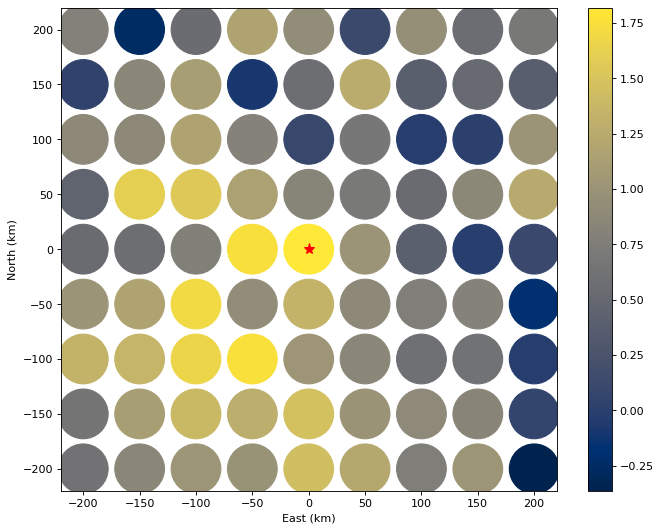

In [11]:
# Plot r for each point of the grid

X, Y = np.zeros([2*nlon+1,2*nlat+1]), np.zeros([2*nlon+1,2*nlat+1])
for j in range(2*nlon+1):
    for k in range(2*nlat+1):
        X[j,k] = grid_spacing * (-nlon + j)
        Y[j,k] = grid_spacing * (-nlat + k)

plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(X,Y,2000,c=r,cmap='cividis')
plt.plot(0,0,'*r',markersize=10)
plt.xlabel('East (km)')
plt.ylabel('North (km)')
plt.colorbar()
#plt.savefig('grid_search.pdf')

In [12]:
# Search the coordinates of the location maximizing the value of r

r_ = r.reshape([(2*nlon+1)*(2*nlat+1),1])
X_ = X.reshape([(2*nlon+1)*(2*nlat+1),1])
Y_ = Y.reshape([(2*nlon+1)*(2*nlat+1),1])
I = np.where(r_==max(r_))[0][0]
X_opt, Y_opt = X_[I][0], Y_[I][0]
print('r is maximum at the location '+str(X_opt)+', '+str(Y_opt))

r is maximum at the location 0.0, 0.0


# Conclusion

We find that the locations that maximize the ratio r (and therefore the amplitude of the signal) are the actual locations of the epicenters. This test highlights that, though low-amplitude and not robust to common-mode filtering, the signal points to the location of the upcoming earthquakes, an observation difficult to reconcile with the hypothesis that this signal originates from noise. 